In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
cwd = os.getcwd()
sep = os.sep

from adin.ml import baselineComparison, train_test_split, create_results_df

d:\anaconda3\envs\eabin13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch 
from adin.utils import set_seed 

def set_deterministic(seed):
    global current_seed
    global is_deterministic

    #FOR REPRODUCIBILITY:
    print(f"SETTING DETERMINISTIC MODE FOR REPRODUCIBILITY, SEED: {seed}")
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"
    torch.use_deterministic_algorithms(True)
    set_seed(seed)
    current_seed = seed 
    is_deterministic = True

set_deterministic(0)

SETTING DETERMINISTIC MODE FOR REPRODUCIBILITY, SEED: 0


In [4]:
pardir = cwd.split(sep)[:-1]
pardir_str = ""
for elem in pardir:
    pardir_str += elem + sep 
pardir = pardir_str
pardir

'c:\\Users\\Utente\\Desktop\\E-ABIN\\'

In [5]:
datasets_path = pardir + "use_case" + sep + "data" 
datasets_name = os.listdir(datasets_path)
datasets_name

['bladder_cancer', 'celiac', 'colorectal_cancer', 'parkinson']

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_class_distribution(
    y_train_dict, y_test_dict, label='Test', 
    class_labels=[0, 1]
):
    """
    Plots class distribution for train and test/validation splits, supporting multiple datasets and both 
    single and cross-validation (k-fold/split list) inputs.

    Args:
        y_train_dict (dict): {dataset_name: labels-array or list of labels-arrays}
        y_test_dict (dict): {dataset_name: labels-array or list of labels-arrays}
        label (str): Name for test/validation split
        class_labels (list): The two class labels (default [0, 1])
    """

    datasets = list(y_train_dict.keys())
    train_props0, train_props1, test_val_props0, test_val_props1 = [], [], [], []

    for ds in datasets:
        # Handle train
        ytr = y_train_dict[ds]
        if isinstance(ytr, list) and isinstance(ytr[0], (list, np.ndarray)):
            # kfold: average over folds
            props0, props1 = [], []
            for y in ytr:
                c = Counter(y)
                t = c.get(class_labels[0], 0) + c.get(class_labels[1], 0)
                props0.append(c.get(class_labels[0], 0) / t if t else 0)
                props1.append(c.get(class_labels[1], 0) / t if t else 0)
            train_props0.append(np.mean(props0))
            train_props1.append(np.mean(props1))
        else:
            # single split input
            c = Counter(ytr)
            t = c.get(class_labels[0], 0) + c.get(class_labels[1], 0)
            train_props0.append(c.get(class_labels[0], 0) / t if t else 0)
            train_props1.append(c.get(class_labels[1], 0) / t if t else 0)

        # Handle test_val
        yte = y_test_dict.get(ds, [])
        if isinstance(yte, list) and isinstance(yte, list) and yte and isinstance(yte[0], (list, np.ndarray)):
            props0, props1 = [], []
            for y in yte:
                c = Counter(y)
                t = c.get(class_labels[0], 0) + c.get(class_labels[1], 0)
                props0.append(c.get(class_labels[0], 0) / t if t else 0)
                props1.append(c.get(class_labels[1], 0) / t if t else 0)
            test_val_props0.append(np.mean(props0))
            test_val_props1.append(np.mean(props1))
        else:
            c = Counter(yte)
            t = c.get(class_labels[0], 0) + c.get(class_labels[1], 0)
            test_val_props0.append(c.get(class_labels[0], 0) / t if t else 0)
            test_val_props1.append(c.get(class_labels[1], 0) / t if t else 0)

    indices = np.arange(len(datasets))
    bar_width = 0.4

    fig, ax = plt.subplots(figsize=(max(8, 1 + len(datasets) * 2), 6))

    # Train bars
    ax.bar(indices - bar_width/2, train_props0, bar_width, label='Train Normal', color='#1f77b4', alpha=0.7)
    ax.bar(indices - bar_width/2, train_props1, bar_width, bottom=train_props0, label='Train Anomalous', color='#ff7f0e', alpha=0.7)

    # Test/val bars
    ax.bar(indices + bar_width/2, test_val_props0, bar_width, label=f'{label} Normal', color='#1f77b4', alpha=0.4)
    ax.bar(indices + bar_width/2, test_val_props1, bar_width, bottom=test_val_props0, label=f'{label} Anomalous', color='#ff7f0e', alpha=0.4)

    # Annotate percentages
    for i in range(len(datasets)):
        ax.text(indices[i]-bar_width/2, train_props0[i]/2, f'{train_props0[i]*100:.1f}%', ha='center', va='center', color='white', fontsize=10)
        ax.text(indices[i]-bar_width/2, train_props0[i]+train_props1[i]/2, f'{train_props1[i]*100:.1f}%', ha='center', va='center', color='white', fontsize=10)
        ax.text(indices[i]+bar_width/2, test_val_props0[i]/2, f'{test_val_props0[i]*100:.1f}%', ha='center', va='center', color='black', fontsize=10)
        ax.text(indices[i]+bar_width/2, test_val_props0[i]+test_val_props1[i]/2, f'{test_val_props1[i]*100:.1f}%', ha='center', va='center', color='black', fontsize=10)

    ax.set_xticks(indices)
    ax.set_xticklabels(datasets)
    ax.set_ylabel('Average Class Proportion')
    ax.set_ylim(0, 1)
    ax.set_title(f'Class Distribution ({label} and Train) Across Datasets')
    ax.legend()
    plt.tight_layout()
    return fig


In [63]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

train_filename = "X_train.npz"
test_filename = "X_test.npz"
datasets = {}

y_train_dict = {}
y_test_dict = {}
y_train_fold_dict = {}
y_validation_dict = {}

for dataset_name in datasets_name:
    dataset_path = datasets_path + sep + dataset_name

    train = np.load(dataset_path + sep + train_filename)
    test = np.load(dataset_path + sep + test_filename)    
    X_train = train['arr_0']
    X_test = test['arr_0']

    y_train = train['arr_1']
    y_test = test['arr_1']
    
    if dataset_name == "bladder_cancer":
        n_splits = 2 
    else:
        n_splits = 5

    print(n_splits, dataset_name)
    fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    y_validation_dict[dataset_name] = []
    y_train_fold_dict[dataset_name] = []

    for train_index, val_index in fold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        y_validation_dict[dataset_name].append(y_val_fold)
        y_train_fold_dict[dataset_name].append(y_train_fold)

    y_train_dict[dataset_name] = y_train
    y_test_dict[dataset_name] = y_test

2 bladder_cancer
5 celiac
5 colorectal_cancer
5 parkinson


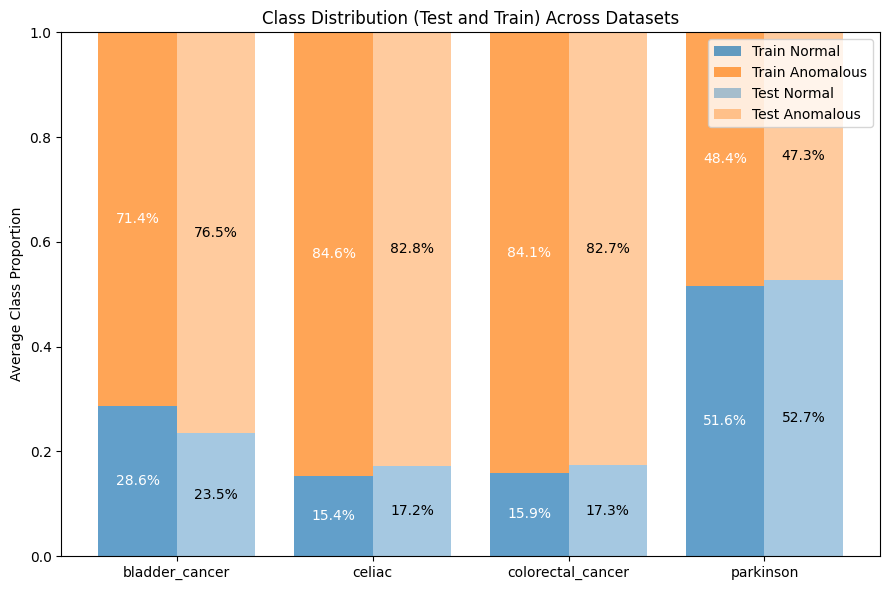

In [64]:
fig = plot_class_distribution(y_train_dict, y_test_dict, label='Test')
fig.savefig("class_distribution_train_test.png", dpi=600, bbox_inches='tight')

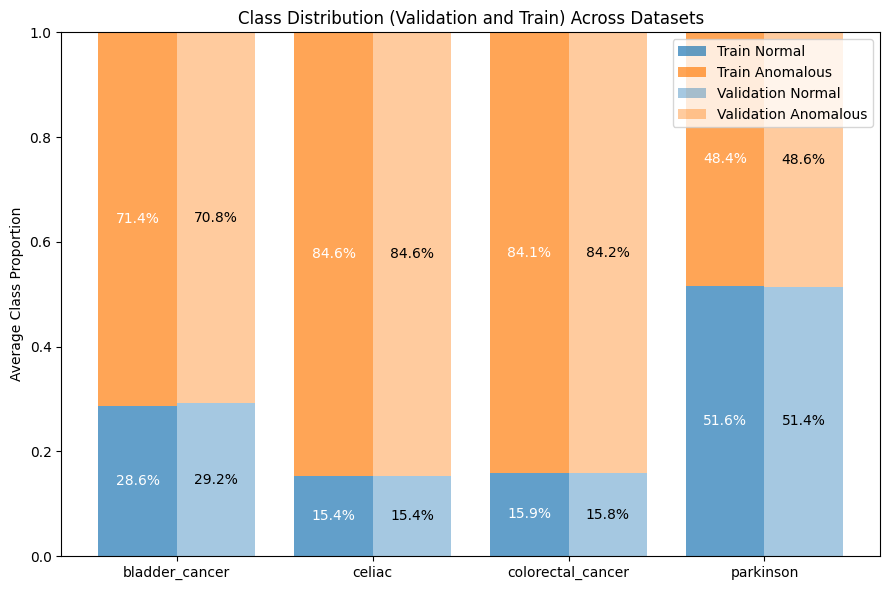

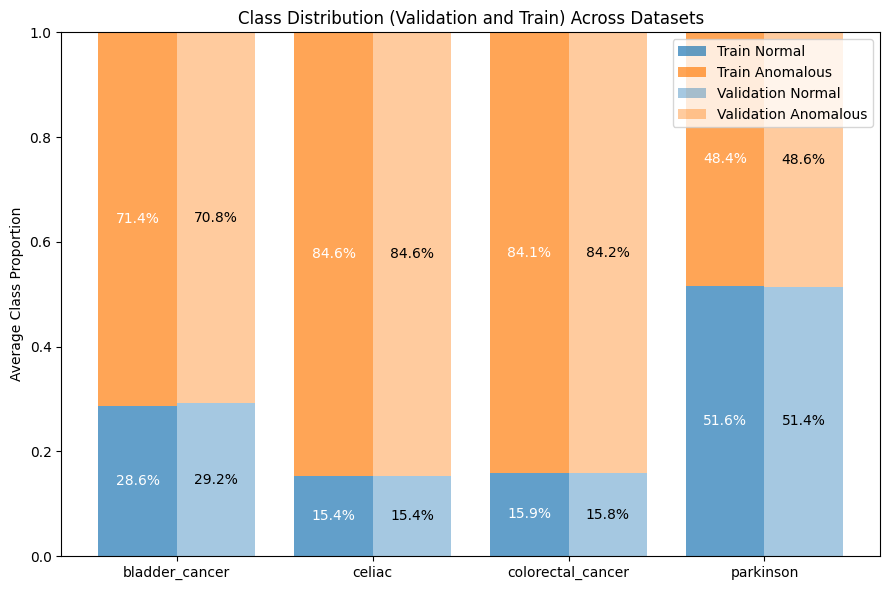

In [65]:
fig = plot_class_distribution(y_train_dict, y_validation_dict, label="Validation")
fig.savefig("class_distribution_train_validation.png", dpi=600, bbox_inches='tight')
fig

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_class_distribution_split_level(
    y_train_dict, y_val_dict, test_val_label="Validation", class_labels=[0, 1]
):
    """
    Plots class distribution for train (average) and per-fold validation splits for multiple datasets.

    Args:
        y_train_dict (dict): {dataset_name: array or list of arrays} (Train can be a single split or kfold, will average)
        y_val_dict (dict): {dataset_name: list of arrays} (Val must be list of kfold splits)
        test_val_label (str): Label for validation split in legend ("Validation" by default)
        class_labels (list): e.g., [0, 1]
    """
    datasets = list(y_train_dict.keys())
    indices = np.arange(len(datasets))
    bar_width = 0.13

    fig, ax = plt.subplots(figsize=(max(8, 2+2*len(datasets)), 6))

    for ds_idx, ds in enumerate(datasets):        
        # Get per-fold val proportions for each class
        val_props0, val_props1 = [], []
        val_folds = y_val_dict[ds]
        n_folds = len(val_folds)
        offset_range = np.linspace(-bar_width*2, bar_width*2, n_folds)
        
        for k, fold in enumerate(val_folds):
            c = Counter(fold)
            t = c.get(class_labels[0], 0) + c.get(class_labels[1], 0)
            prop0 = c.get(class_labels[0], 0) / t if t else 0
            prop1 = c.get(class_labels[1], 0) / t if t else 0

            pos = indices[ds_idx] + offset_range[k]

            # Only label the first appearance of each class, then skip labels
            label0 = "Normal" if (ds_idx == 0 and k == 0) else ""
            label1 = "Anomalous" if (ds_idx == 0 and k == 0) else ""

            ax.bar(
                pos, prop0, bar_width, 
                label=label0, color="#1f77b4", alpha=0.6
            )
            ax.bar(
                pos, prop1, bar_width, bottom=prop0, 
                label=label1, color="#ff7f0e", alpha=0.6
            )
            # Annotate
            ax.text(pos, prop0/2, f'{prop0*100:.1f}%', ha='center', va='center', color='white', fontsize=6)
            ax.text(pos, prop0+prop1/2, f'{prop1*100:.1f}%', ha='center', va='center', color='white', fontsize=6)

    ax.set_xticks(indices)
    ax.set_xticklabels(datasets)
    ax.set_ylabel('Class Proportion')
    ax.set_ylim(0,1)
    ax.set_title('Train-Validation Per-Fold Class Distribution')
    ax.legend(ncol=2)
    plt.tight_layout()
    return fig


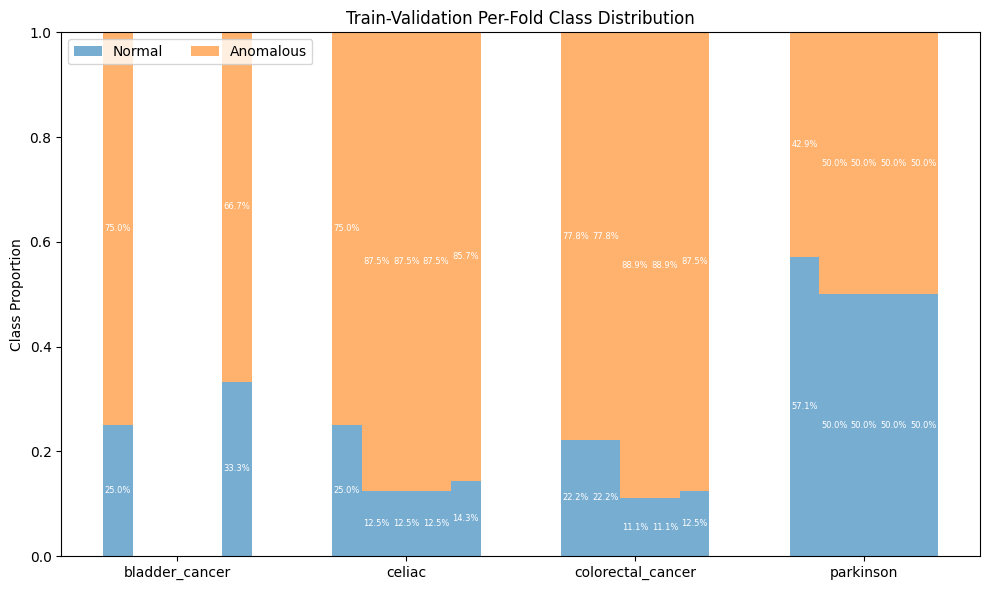

In [67]:
fig = plot_class_distribution_split_level(y_train_dict, y_validation_dict, test_val_label="Validation")
fig.savefig(
    "class_distribution_train_validation_split_level.png", dpi=600, bbox_inches='tight'
)